## Using scMKL with single-cell RNA Data
To run tutorials, install `jupyter` into your scMKL env with `pip install jupyter` or `conda install jupyter`.
Here we will run scMKL on a subset of the MCF-7 data (1,000 cells x 36,601 genes) using Hallmark groupings to predict estrogen-treated (E2) versus control (Vehicle) cells.

### Importing Modules
Data is read-in and saved using Numpy and SciPy modules.

In [1]:
import scmkl

# Packages needed for reading and writing data
import pickle
import numpy as np
from scipy.sparse import load_npz

### Reading in Data
There are four pieces of data (per modality) required for scMKL:
- The data matrix itself with cells as rows and features as columns.
    - Can be either a Numpy array or SciPy sparse array (scipy.sparse.csc_array is the recommended format).  
- The sample labels in a Numpy array. To perform group lasso, these labels must be binary.
- Feature names in a Numpy array. These are the names of the features corresponding with the data matrix columns.
- A dictionary with grouping data.  The keys are the names of the groups, and the values are the corresponding features.
    - Example: {Group1: [feature1, feature2, feature3], Group2: [feature4, feature5, feature6], ...}.
    - See `getting_RNA_groupings.ipynb` for more information on pulling gene sets.

In [2]:
# Reading in grouping dictionary from pickle file
group_dict = np.load('./data/_RNA_hallmark_groupings.pkl', allow_pickle = True)

# Reading in data to be analyzed
X = load_npz('data/_MCF7_RNA_X.npz')
cell_labels = np.load('data/_MCF7_cell_labels.npy', allow_pickle = True)
feature_names = np.load('data/_MCF7_RNA_feature_names.npy', allow_pickle = True)

### Creating an AnnData Object
scMKL takes advantage of AnnData's flexible structure to create a straight-forward approach to running scMKL. Using `scmkl.create_adata()` will create an AnnData object from input data that will include necessary variables for running scMKL. For more information, see scMKL's [documentation](https://ohsu-cedar-comp-hub.github.io/scMKL/). Given the ATAC data we are working with is binary, it will not be transformed or scaled. By not specifying the `split_data` parameter, a train/test split is automatically calculated using the `random_state` parameter.

In [3]:
adata = scmkl.create_adata(X=X, 
                         feature_names=feature_names, 
                         cell_labels=cell_labels, 
                         group_dict=group_dict,
                         random_state=5)

### Calculating Z
The Z matrices are a the Fourier transform of the grouped data matrix. This is calculated on training and testing samples separately. 

Returns Z matrices for training and testing in adata object with `adata.uns['Z_train']` and `adata.uns['Z_test']`.

If sigmas are not precalculated with `scmkl.estimate_sigma()`, they will automatically be calculated within `scmkl.calculate_z`.

In [4]:
adata = scmkl.calculate_z(adata, batch_size=80)

### Optimizing Sparsity
Sparsity (lambda) or `alpha` here, is the regularization coefficient that controls the pentalty to run with the model. 

This will ultimately decide how many groups will be used in the final model.

`scmkl.optimize_alpha()` returns a single sparsity value as the optimal sparsity argument for training the model.

In [5]:
# Setting a list of alpha values to train the model with
alpha_list = np.round(np.linspace(2.2,0.05,10), 2)

# Calculating the best performing alpha from cross validation on training data
alpha_star = scmkl.optimize_alpha(adata, alpha_array=alpha_list, k=4, batch_size=60)

### Training and Evalutating Model
Here we will train and evaluate 10 models, each with a different `alpha`.

`alpha` (or lambda) is a regularization coefficient that deterimines how many groupings will be used to classify the test cells in the final model. Here, we will evalutate the model using a range of alphas (`alpha_list`) to get a range of selected groups.

In [6]:
results = scmkl.run(adata, alpha_list=alpha_list)

  Evaluating model. Alpha: 2.2
  Evaluating model. Alpha: 1.96
  Evaluating model. Alpha: 1.72
  Evaluating model. Alpha: 1.48
  Evaluating model. Alpha: 1.24
  Evaluating model. Alpha: 1.01
  Evaluating model. Alpha: 0.77
  Evaluating model. Alpha: 0.53
  Evaluating model. Alpha: 0.29
  Evaluating model. Alpha: 0.05


### Model Performance and Top Groups per Alpha

In [7]:
summary_df = scmkl.get_summary(results)
summary_df

,Alpha,AUROC,Number of Selected Groups,Top Group
0,2.20,0.9119,7,HALLMARK_ESTROGEN_RESPONSE_LATE
1,1.96,0.9403,8,HALLMARK_ESTROGEN_RESPONSE_LATE
2,1.72,0.9556,12,HALLMARK_ESTROGEN_RESPONSE_LATE
3,1.48,0.9655,14,HALLMARK_ESTROGEN_RESPONSE_LATE
4,1.24,0.9722,16,HALLMARK_ESTROGEN_RESPONSE_LATE
5,1.01,0.9776,20,HALLMARK_ESTROGEN_RESPONSE_LATE
6,0.77,0.9835,25,HALLMARK_ESTROGEN_RESPONSE_LATE
7,0.53,0.9868,30,HALLMARK_ESTROGEN_RESPONSE_LATE
8,0.29,0.9867,33,HALLMARK_ESTROGEN_RESPONSE_LATE
9,0.05,0.9638,42,HALLMARK_ESTROGEN_RESPONSE_LATE


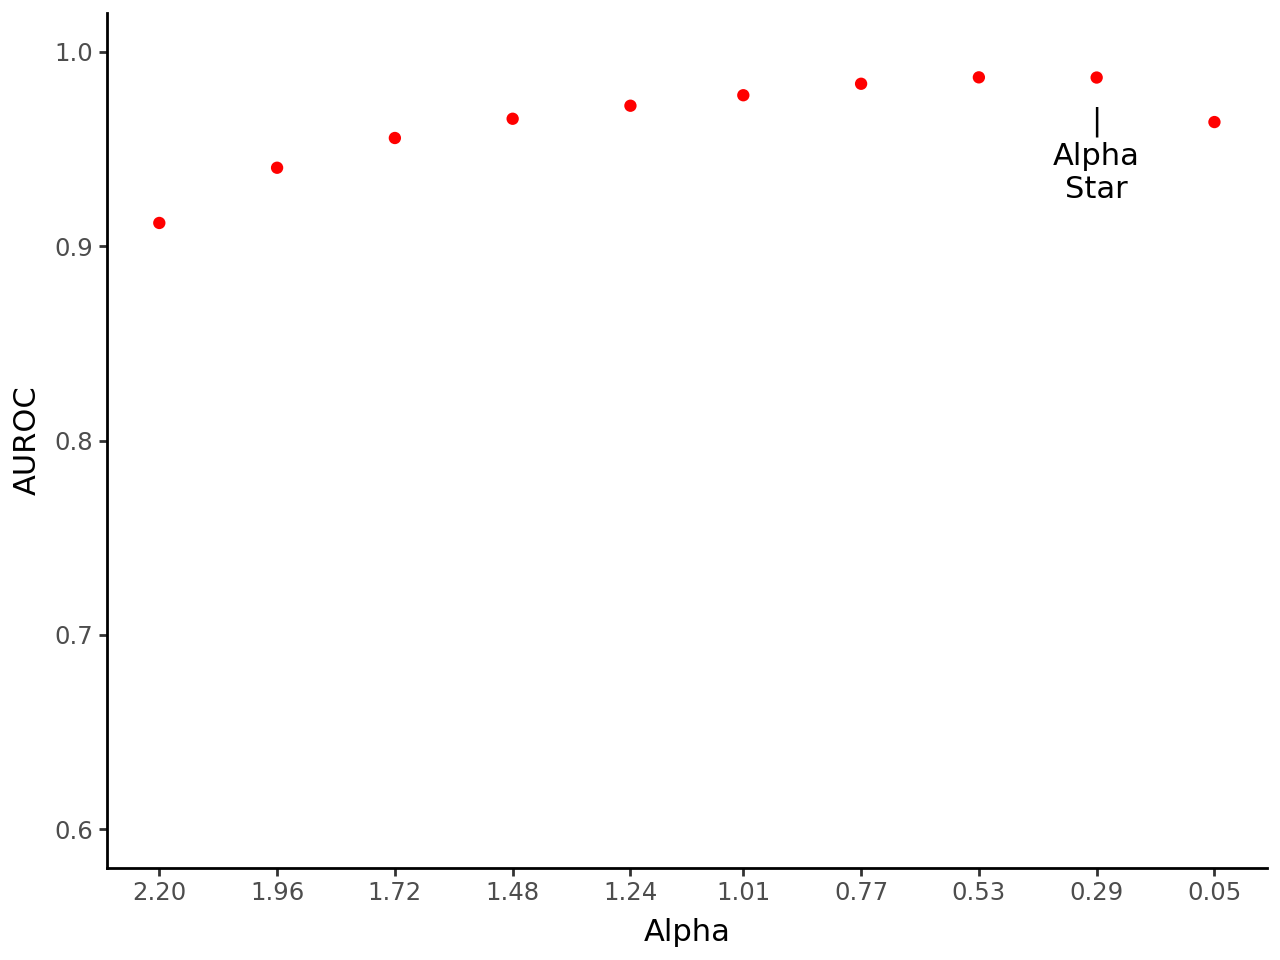

In [8]:
metric_plot = scmkl.plot_metric(summary_df, color = 'red', alpha_star = alpha_star)
metric_plot.show()

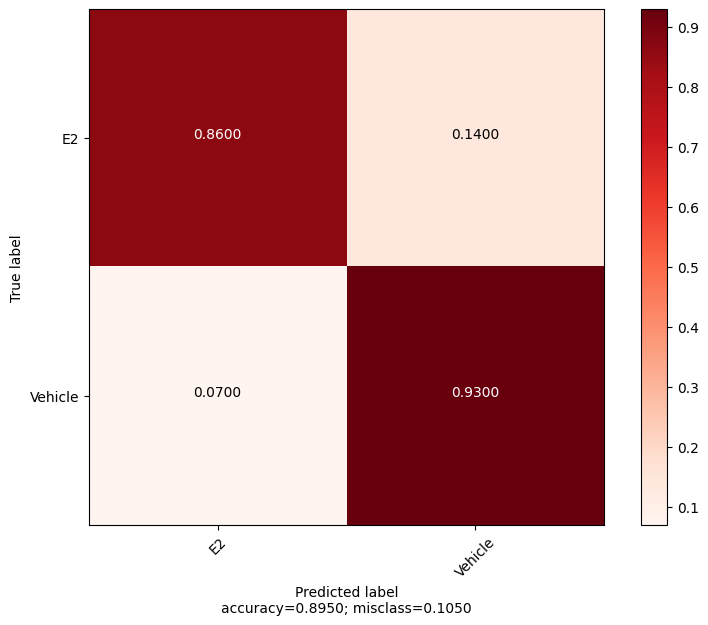

In [9]:
from matplotlib.pyplot import get_cmap

scmkl.plot_conf_mat(results, title='', cmap=get_cmap('Reds'))

### Saving results
Using the Numpy's implementation of the pickle module, we can save the results as a pickle file (`.pkl`).

In [10]:
with open('data/MCF7_RNA_results.pkl', 'wb') as outfile:
    pickle.dump(results, outfile)